<a href="https://colab.research.google.com/github/Pitap4ik/Stock-market-prerdictions/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3083]:
import yfinance as yf
import pandas as pd
import os
import numpy as np

In [3084]:
from google.colab import files
uploaded = files.upload()

Saving ETHUSDT_daily_binance.xlsx to ETHUSDT_daily_binance (6).xlsx


In [3225]:
# if os.path.exists("D:\Ass2\ETHUSDT_1h_latest.csv"):
#     sp500 = pd.read_csv("D:\Ass2\ETHUSDT_1h_latest.csv", index_col=0)
# else:
#     sp500 = yf.Ticker("^GSPC")
#     sp500 = sp500.history(period="max")
#     sp500.to_csv("sp500.csv")

In [3226]:
sp500 = pd.read_excel("ETHUSDT_daily_binance (5).xlsx")

In [3227]:
#sp500.index = pd.to_datetime(sp500.index)
sp500.columns = [col.capitalize() for col in sp500.columns]
sp500['Close']=[float(x) for x in sp500['Close']]
sp500['Volume']=[float(x) for x in sp500['Volume']]
sp500['Open']=[float(x) for x in sp500['Open']]
sp500['High']=[float(x) for x in sp500['High']]
sp500['Low']=[float(x) for x in sp500['Low']]
#sp500 = sp500.drop('Volume', axis=1)

In [3228]:
sp500['OBV'] = (np.sign(sp500['Close'].diff()) * sp500['Volume']).fillna(0).cumsum()

In [3229]:
sp500['OBV_previus'] = (np.sign(sp500['Close'].shift(1).diff()) * sp500['Volume'].shift(1)).fillna(0).cumsum()

In [3230]:
sp500['Williams_R'] = ((sp500['High'].rolling(window=14).max() - sp500['Close']) /
                     (sp500['High'].rolling(window=14).max() - sp500['Low'].rolling(window=14).min())) * -100

In [3231]:
def calculate_parabolic_sar(df, af_start=0.02, af_increment=0.02, af_max=0.2):
    high = df['High']
    low = df['Low']
    close = df['Close']

    # Initialization
    sar = [low.iloc[0]]  # Start SAR at the first low
    uptrend = True  # Assume starting with uptrend
    af = af_start  # Acceleration Factor
    ep = high.iloc[0]  # Extreme Point

    for i in range(1, len(df)):
        prev_sar = sar[-1]

        if uptrend:
            new_sar = prev_sar + af * (ep - prev_sar)
            new_sar = min(new_sar, low.iloc[i-1], low.iloc[i])  # SAR cannot be above last two lows
        else:
            new_sar = prev_sar - af * (prev_sar - ep)
            new_sar = max(new_sar, high.iloc[i-1], high.iloc[i])  # SAR cannot be below last two highs

        reverse = False
        if uptrend:
            if low.iloc[i] < new_sar:
                uptrend = False
                reverse = True
                new_sar = ep
                ep = low.iloc[i]
                af = af_start
        else:
            if high.iloc[i] > new_sar:
                uptrend = True
                reverse = True
                new_sar = ep
                ep = high.iloc[i]
                af = af_start

        if not reverse:
            if uptrend:
                if high.iloc[i] > ep:
                    ep = high.iloc[i]
                    af = min(af + af_increment, af_max)
            else:
                if low.iloc[i] < ep:
                    ep = low.iloc[i]
                    af = min(af + af_increment, af_max)

        sar.append(new_sar)

    df['Parabolic_SAR'] = sar
    return df

In [3232]:
sp500 = calculate_parabolic_sar(sp500)

In [3233]:
sp500["Parabolic_SAR"]=sp500["Close"]/sp500["Parabolic_SAR"]

In [3234]:
sp500

,Timestamp,Open,High,Low,Close,Volume,OBV,OBV_previus,Williams_R,Parabolic_SAR
0,2021-03-21 00:00:00,1806.57,1817.16,1747.00,1782.98,465953.98749,0.000000e+00,0.000000e+00,NaN,1.020595
1,2021-03-22 00:00:00,1783.23,1807.51,1655.15,1680.97,582727.49081,-5.827275e+05,0.000000e+00,NaN,1.015600
2,2021-03-23 00:00:00,1681.17,1721.17,1650.00,1668.08,577213.99589,-1.159941e+06,-5.827275e+05,NaN,1.010958
3,2021-03-24 00:00:00,1668.20,1740.86,1536.92,1581.84,753834.52393,-1.913776e+06,-1.159941e+06,NaN,1.029227
4,2021-03-25 00:00:00,1581.88,1622.00,1549.40,1585.74,701697.00258,-1.212079e+06,-1.913776e+06,NaN,1.031765
...,...,...,...,...,...,...,...,...,...,...
1495,2025-04-24 00:00:00,1795.08,1802.82,1722.90,1769.65,483465.03850,-1.252715e+07,-1.204369e+07,-19.746843,1.027134
1496,2025-04-25 00:00:00,1769.64,1827.32,1738.60,1784.60,595610.88940,-1.193154e+07,-1.252715e+07,-16.888441,1.035812
1497,2025-04-26 00:00:00,1784.60,1841.16,1778.94,1820.88,355068.04420,-1.157647e+07,-1.193154e+07,-6.673248,1.047325
1498,2025-04-27 00:00:00,1820.87,1857.47,1781.90,1791.29,340332.64350,-1.191680e+07,-1.157647e+07,-20.667687,1.006942


<Axes: >

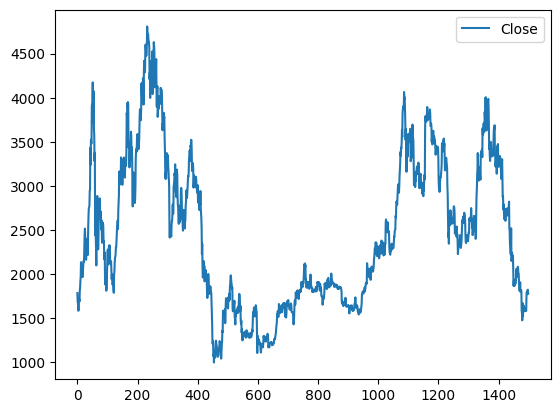

In [3235]:
sp500.plot.line(y="Close", use_index=True)

In [3236]:
# del sp500["Dividends"]
# del sp500["Stock Splits"]

In [3237]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)-sp500["Open"].shift(-1)

In [3238]:
sp500["Tomorrow_low"] = sp500["Low"].shift(-1)-sp500["Open"].shift(-1)

In [3239]:
sp500["Target"] = (sp500["Tomorrow"] >0).astype(int)

In [3240]:
sp500["Percent"] = sp500["Tomorrow"]/sp500["Close"]

In [3241]:
sp500["Percent_low"] = sp500["Tomorrow_low"]/sp500["Close"]

In [3242]:
def calculate_rsi(df, period=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_stochrsi(df, period=14, smooth_period=3):
    rsi = calculate_rsi(df, period)
    rsi_min = rsi.rolling(window=period).min()
    rsi_max = rsi.rolling(window=period).max()
    stochrsi = (rsi - rsi_min) / (rsi_max - rsi_min)
    stochrsi_smooth = stochrsi.rolling(window=smooth_period).mean()  # Optional smoothing
    return stochrsi_smooth

In [3243]:
sp500['TP'] = (sp500['High'] + sp500['Low'] + sp500['Close']) / 3
sp500['CCI'] = (sp500['TP'] - sp500['TP'].rolling(window=20).mean()) / (0.015 * sp500['TP'].rolling(window=20).std())

In [3244]:
sp500["Stoch_RSI"] = calculate_stochrsi(sp500)

In [3245]:
sp500

,Timestamp,Open,High,Low,Close,Volume,OBV,OBV_previus,Williams_R,Parabolic_SAR,Tomorrow,Tomorrow_low,Target,Percent,Percent_low,TP,CCI,Stoch_RSI
0,2021-03-21 00:00:00,1806.57,1817.16,1747.00,1782.98,465953.98749,0.000000e+00,0.000000e+00,NaN,1.020595,-102.26,-128.08,0,-0.057353,-0.071835,1782.380000,NaN,NaN
1,2021-03-22 00:00:00,1783.23,1807.51,1655.15,1680.97,582727.49081,-5.827275e+05,0.000000e+00,NaN,1.015600,-13.09,-31.17,0,-0.007787,-0.018543,1714.543333,NaN,NaN
2,2021-03-23 00:00:00,1681.17,1721.17,1650.00,1668.08,577213.99589,-1.159941e+06,-5.827275e+05,NaN,1.010958,-86.36,-131.28,0,-0.051772,-0.078701,1679.750000,NaN,NaN
3,2021-03-24 00:00:00,1668.20,1740.86,1536.92,1581.84,753834.52393,-1.913776e+06,-1.159941e+06,NaN,1.029227,3.86,-32.48,1,0.002440,-0.020533,1619.873333,NaN,NaN
4,2021-03-25 00:00:00,1581.88,1622.00,1549.40,1585.74,701697.00258,-1.212079e+06,-1.913776e+06,NaN,1.031765,113.01,-0.04,1,0.071266,-0.000025,1585.713333,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2025-04-24 00:00:00,1795.08,1802.82,1722.90,1769.65,483465.03850,-1.252715e+07,-1.204369e+07,-19.746843,1.027134,14.96,-31.04,1,0.008454,-0.017540,1765.123333,117.930108,0.933610
1496,2025-04-25 00:00:00,1769.64,1827.32,1738.60,1784.60,595610.88940,-1.193154e+07,-1.252715e+07,-16.888441,1.035812,36.28,-5.66,1,0.020329,-0.003172,1783.506667,136.769508,0.919688
1497,2025-04-26 00:00:00,1784.60,1841.16,1778.94,1820.88,355068.04420,-1.157647e+07,-1.193154e+07,-6.673248,1.047325,-29.58,-38.97,0,-0.016245,-0.021402,1813.660000,136.321059,0.950048
1498,2025-04-27 00:00:00,1820.87,1857.47,1781.90,1791.29,340332.64350,-1.191680e+07,-1.157647e+07,-20.667687,1.006942,-14.63,-39.11,0,-0.008167,-0.021833,1810.220000,116.351812,0.936050


In [3246]:
# sp500.index = pd.to_datetime(sp500.index, utc=True)
# sp500 = sp500.loc["1990-01-01":].copy()

In [3247]:
sp500

,Timestamp,Open,High,Low,Close,Volume,OBV,OBV_previus,Williams_R,Parabolic_SAR,Tomorrow,Tomorrow_low,Target,Percent,Percent_low,TP,CCI,Stoch_RSI
0,2021-03-21 00:00:00,1806.57,1817.16,1747.00,1782.98,465953.98749,0.000000e+00,0.000000e+00,NaN,1.020595,-102.26,-128.08,0,-0.057353,-0.071835,1782.380000,NaN,NaN
1,2021-03-22 00:00:00,1783.23,1807.51,1655.15,1680.97,582727.49081,-5.827275e+05,0.000000e+00,NaN,1.015600,-13.09,-31.17,0,-0.007787,-0.018543,1714.543333,NaN,NaN
2,2021-03-23 00:00:00,1681.17,1721.17,1650.00,1668.08,577213.99589,-1.159941e+06,-5.827275e+05,NaN,1.010958,-86.36,-131.28,0,-0.051772,-0.078701,1679.750000,NaN,NaN
3,2021-03-24 00:00:00,1668.20,1740.86,1536.92,1581.84,753834.52393,-1.913776e+06,-1.159941e+06,NaN,1.029227,3.86,-32.48,1,0.002440,-0.020533,1619.873333,NaN,NaN
4,2021-03-25 00:00:00,1581.88,1622.00,1549.40,1585.74,701697.00258,-1.212079e+06,-1.913776e+06,NaN,1.031765,113.01,-0.04,1,0.071266,-0.000025,1585.713333,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2025-04-24 00:00:00,1795.08,1802.82,1722.90,1769.65,483465.03850,-1.252715e+07,-1.204369e+07,-19.746843,1.027134,14.96,-31.04,1,0.008454,-0.017540,1765.123333,117.930108,0.933610
1496,2025-04-25 00:00:00,1769.64,1827.32,1738.60,1784.60,595610.88940,-1.193154e+07,-1.252715e+07,-16.888441,1.035812,36.28,-5.66,1,0.020329,-0.003172,1783.506667,136.769508,0.919688
1497,2025-04-26 00:00:00,1784.60,1841.16,1778.94,1820.88,355068.04420,-1.157647e+07,-1.193154e+07,-6.673248,1.047325,-29.58,-38.97,0,-0.016245,-0.021402,1813.660000,136.321059,0.950048
1498,2025-04-27 00:00:00,1820.87,1857.47,1781.90,1791.29,340332.64350,-1.191680e+07,-1.157647e+07,-20.667687,1.006942,-14.63,-39.11,0,-0.008167,-0.021833,1810.220000,116.351812,0.936050


In [3248]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Open", "High", "Low","Stoch_RSI",'CCI', "Volume",'OBV','Williams_R','Parabolic_SAR']#'Parabolic_SAR']
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [3249]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.48

<Axes: >

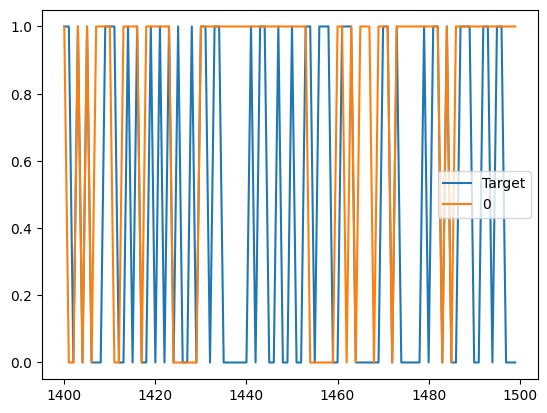

In [3250]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [3251]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [3252]:
def backtest(data, model, predictors, start=500, step=50):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [3253]:
predictions = backtest(sp500, model, predictors)

In [3254]:
predictions["Predictions"].value_counts()

,count
Predictions,
0,513
1,487


In [3255]:
precision_score(predictions["Target"], predictions["Predictions"])

0.4948665297741273

In [3256]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
0,0.5
1,0.5


In [3257]:
horizons = [2,3,5,10,20,50,100,200]
new_predictors = []#"Close", "Open", "High", "Low","Stoch_RSI",'CCI', "Volume",'OBV','Williams_R','Parabolic_SAR']'OBV_previus'

for horizon in horizons:
    rolling_averages = sp500[['Close']].rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    print(rolling_averages.columns)

    # ex_avarages= sp500['Close'].ewm(span=horizon, adjust=False).mean()

    # ex_ratio_column = f"Close_Ratio_EW_{horizon}"
    # sp500[ex_ratio_column] = sp500["Close"] / ex_avarages

    # trend_column = f"Trend_{horizon}"
    # sp500[trend_column] = sp500['Target'].shift(1).rolling(horizon).sum()

    new_predictors+= [ratio_column] #trend_column]ratio_column

Index(['Close'], dtype='object')
Index(['Close'], dtype='object')
Index(['Close'], dtype='object')
Index(['Close'], dtype='object')
Index(['Close'], dtype='object')
Index(['Close'], dtype='object')
Index(['Close'], dtype='object')
Index(['Close'], dtype='object')


In [3258]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [3259]:
sp500

,Timestamp,Open,High,Low,Close,Volume,OBV,OBV_previus,Williams_R,Parabolic_SAR,...,CCI,Stoch_RSI,Close_Ratio_2,Close_Ratio_3,Close_Ratio_5,Close_Ratio_10,Close_Ratio_20,Close_Ratio_50,Close_Ratio_100,Close_Ratio_200
199,2021-10-06 00:00:00,3515.48,3632.11,3342.00,3574.89,618265.5402,1.430993e+07,1.369167e+07,-6.364071,1.069686,...,98.860118,0.960687,1.008409,1.023691,1.034284,1.111131,1.130941,1.077877,1.244915,1.329442
200,2021-10-07 00:00:00,3574.88,3653.98,3470.80,3587.47,486102.3591,1.479603e+07,1.430993e+07,-7.221655,1.073450,...,108.011815,0.909412,1.001756,1.007940,1.026066,1.092565,1.131562,1.077945,1.243140,1.329659
201,2021-10-08 00:00:00,3587.47,3695.00,3532.00,3563.13,403597.1437,1.439244e+07,1.479603e+07,-13.781968,1.026602,...,108.285844,0.909412,0.996596,0.996634,1.010698,1.060660,1.121630,1.068199,1.229221,1.316048
202,2021-10-09 00:00:00,3563.13,3635.00,3538.07,3574.82,361906.7514,1.475434e+07,1.439244e+07,-12.560225,1.012123,...,97.024734,0.948725,1.001638,0.999910,1.003285,1.041678,1.120966,1.069843,1.227038,1.315732
203,2021-10-10 00:00:00,3574.83,3604.00,3405.00,3414.22,580223.6302,1.417412e+07,1.475434e+07,-30.753560,1.002708,...,64.691941,0.911372,0.977021,0.970669,0.963678,0.983032,1.063321,1.020615,1.166866,1.252399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,2025-04-23 00:00:00,1756.25,1834.86,1744.95,1795.07,887545.6316,-1.204369e+07,-1.293123e+07,-10.936126,1.167707,...,131.777804,0.933610,1.010928,1.049564,1.077275,1.101713,1.103841,0.980764,0.766314,0.651573
1495,2025-04-24 00:00:00,1795.08,1802.82,1722.90,1769.65,483465.0385,-1.252715e+07,-1.204369e+07,-19.746843,1.027134,...,117.930108,0.933610,0.992869,0.997739,1.042453,1.076474,1.089791,0.971888,0.760187,0.643128
1496,2025-04-25 00:00:00,1769.64,1827.32,1738.60,1784.60,595610.8894,-1.193154e+07,-1.252715e+07,-16.888441,1.035812,...,136.769508,0.919688,1.004206,1.000837,1.027386,1.072789,1.099723,0.984615,0.772138,0.649314
1497,2025-04-26 00:00:00,1784.60,1841.16,1778.94,1820.88,355068.0442,-1.157647e+07,-1.193154e+07,-6.673248,1.047325,...,136.321059,0.950048,1.010062,1.016281,1.019934,1.078792,1.113839,1.008199,0.792937,0.663263


In [3260]:
model = RandomForestClassifier(n_estimators=300, min_samples_split=50, random_state=2)

In [3261]:
# def predict(train, test, predictors, model):
#     model.fit(train[predictors], train["Target"])
#     preds = model.predict_proba(test[predictors])[:,1]
#     real_preds = pd.Series(preds, index=test.index, name="Real_predictions")
#     preds[preds >=.54] = 1
#     preds[preds <.54] = 0
#     preds = pd.Series(preds, index=test.index, name="Predictions")
#     combined = pd.concat([test['Timestamp'], test["Target"], preds, real_preds, test["Percent"]], axis=1)
#     return combined

In [3262]:
def predict(train, test, predictors, model):
    # Fit the model on the training data
    model.fit(train[predictors], train["Target"])

    # Generate raw probability predictions
    preds = model.predict_proba(test[predictors])[:,1]

    # Create the "Real_predictions" Series from the raw probabilities
    real_preds = pd.Series(preds, index=test.index, name="Real_predictions")

    # Create a copy of the raw predictions to avoid modifying the original array
    preds_copy = preds.copy()

    # Apply thresholding to convert probabilities into binary predictions
    preds_copy[preds_copy >= .54] = 1
    preds_copy[preds_copy < .54] = 0

    # Create the "Predictions" Series from the thresholded predictions
    preds = pd.Series(preds_copy, index=test.index, name="Predictions")

    # Combine the results into a single DataFrame
    combined = pd.concat([test['Timestamp'], test["Target"], preds, real_preds, test["Percent"], test["Percent_low"], test["Stoch_RSI"]], axis=1)

    return combined

In [3263]:
predictions = backtest(sp500, model, new_predictors)

In [3264]:
predictions["Predictions"].value_counts()

,count
Predictions,
0.0,559
1.0,241


In [3265]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5601659751037344

In [3266]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.50125
0,0.49875


In [3267]:
predictions=predictions[predictions['Predictions']==1]

In [3268]:
predictions["Timestamp"]=pd.to_datetime(predictions["Timestamp"])
predictions["Duration"]=predictions["Timestamp"].diff()

In [3269]:
predictions_copy=predictions.copy()

In [3270]:
predictions

,Timestamp,Target,Predictions,Real_predictions,Percent,Percent_low,Stoch_RSI,Duration
705,2023-02-24,0,1.0,0.593302,-0.008222,-0.031391,0.847267,NaT
706,2023-02-25,1,1.0,0.579804,0.029337,-0.004277,0.909265,1 days
709,2023-02-28,1,1.0,0.613070,0.037365,-0.006379,0.815533,3 days
712,2023-03-03,0,1.0,0.569910,-0.001733,-0.012954,0.058129,3 days
717,2023-03-08,0,1.0,0.620034,-0.062034,-0.081168,0.064749,5 days
...,...,...,...,...,...,...,...,...
1487,2025-04-16,1,1.0,0.551685,0.004102,-0.008845,0.815699,1 days
1489,2025-04-18,1,1.0,0.556500,0.015529,-0.002260,0.875614,2 days
1496,2025-04-25,1,1.0,0.545429,0.020329,-0.003172,0.919688,7 days
1497,2025-04-26,0,1.0,0.559654,-0.016245,-0.021402,0.950048,1 days


In [3271]:
for i in range(len(predictions)):
  if predictions.iloc[i,4]*100<-1:
    print(predictions.iloc[i,0],predictions.iloc[i,3], predictions.iloc[i,4]*100,predictions.iloc[i,5]*100,predictions.iloc[i,6])

2023-03-08 00:00:00 0.6200344552937684 -6.2034221276706925 -8.116785653689039 0.06474901151922106
2023-04-20 00:00:00 0.5594937183821028 -4.848222832967918 -6.0721160279570565 0.259161160598783
2023-04-23 00:00:00 0.5816187104769611 -1.0832438238453317 -3.008055853920515 0.04190291697764958
2023-04-30 00:00:00 0.5939634992003542 -2.1041768043249207 -3.4201562491644806 0.01750009201666602
2023-05-06 00:00:00 0.6055762258315629 -1.3673780407418454 -1.515559000806822 0.7539893102874764
2023-05-07 00:00:00 0.6070018741406732 -1.2216638152266968 -3.1907613344739127 0.7513373818841895
2023-06-09 00:00:00 0.5578268825402343 -4.827290164477791 -6.810587001526863 0.20826387076398326
2023-07-04 00:00:00 0.5460846241195559 -1.334056399132329 -2.152670178700551 0.8853030241132904
2023-07-05 00:00:00 0.6319260079260092 -3.3595762055319334 -3.3684750518226885 0.5537407479897732
2023-08-15 00:00:00 0.593775864422593 -1.1574757515117755 -1.6845454843683334 0.40412993211944
2023-08-16 00:00:00 0.596444

In [3272]:
indexes_to_drop = []

# Loop through all rows except the last one
for i in range(len(predictions_copy) - 1):
    if (predictions.iloc[i+1, 0] - predictions.iloc[i, 0] == pd.Timedelta(days=1)):
        predictions.iloc[i+1, 4] = ((1 + predictions.iloc[i+1, 4]) * (1 + predictions.iloc[i, 4]))-1
        indexes_to_drop.append(predictions.index[i])  # Mark this row to drop

# After the loop, drop all marked rows
predictions.drop(index=indexes_to_drop, inplace=True)

In [3273]:
predictions

,Timestamp,Target,Predictions,Real_predictions,Percent,Percent_low,Stoch_RSI,Duration
706,2023-02-25,1,1.0,0.579804,0.020873,-0.004277,0.909265,1 days
709,2023-02-28,1,1.0,0.613070,0.037365,-0.006379,0.815533,3 days
712,2023-03-03,0,1.0,0.569910,-0.001733,-0.012954,0.058129,3 days
717,2023-03-08,0,1.0,0.620034,-0.062034,-0.081168,0.064749,5 days
727,2023-03-18,1,1.0,0.549628,0.012417,-0.000523,0.917082,10 days
...,...,...,...,...,...,...,...,...
1481,2025-04-10,1,1.0,0.614779,0.029305,-0.011568,0.262042,2 days
1484,2025-04-13,1,1.0,0.581122,0.016279,-0.001377,0.719568,3 days
1487,2025-04-16,1,1.0,0.551685,-0.003248,-0.008845,0.815699,1 days
1489,2025-04-18,1,1.0,0.556500,0.015529,-0.002260,0.875614,2 days


In [3274]:
#predictions.plot()

In [3275]:
S = 100
for i in range(len(predictions)):
  print(predictions.iloc[i][4]*100, predictions.iloc[i][0])
  S=S*(1+(predictions.iloc[i][4]+0.0005)*4-0.001*4)
print(S)

2.087324294066417 2023-02-25 00:00:00
3.7365361973050604 2023-02-28 00:00:00
-0.1733091210296618 2023-03-03 00:00:00
-6.2034221276706925 2023-03-08 00:00:00
1.2417275022173788 2023-03-18 00:00:00
3.9508766259998405 2023-03-20 00:00:00
4.581019759791968 2023-03-22 00:00:00
-0.43953657184335737 2023-03-24 00:00:00
3.368664078077446 2023-03-27 00:00:00
2.759128956598453 2023-04-09 00:00:00
-3.498409863898133 2023-04-24 00:00:00
1.1493649010319018e-05 2023-05-01 00:00:00
-2.6266522401206305 2023-05-08 00:00:00
0.732319010198969 2023-05-11 00:00:00
0.6531301372906202 2023-05-18 00:00:00
0.31724160920944106 2023-05-24 00:00:00
0.422170559019339 2023-05-29 00:00:00
-0.6324621189882813 2023-05-31 00:00:00
-4.3992526309253766 2023-06-09 00:00:00
0.5417473434750297 2023-06-18 00:00:00
1.1020240276494306 2023-06-22 00:00:00
1.2720271365789089 2023-06-24 00:00:00
1.6466107575700466 2023-06-26 00:00:00
5.785470526195002 2023-06-29 00:00:00
-4.617638427464643 2023-07-07 00:00:00
6.7177389780431085 2

<ipython-input-3275-b4cdb60f2319>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(predictions.iloc[i][4]*100, predictions.iloc[i][0])
<ipython-input-3275-b4cdb60f2319>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S=S*(1+(predictions.iloc[i][4]+0.0005)*4-0.001*4)
